# Import libraries

In [1]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from unsloth import FastLanguageModel

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


# Set paths and variables

In [2]:
# Model name to load its tokenizer
unsloth_model_name = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit"

# Base path for the historical_mt directory
base_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

# Path to the dataset
file_path = os.path.join(base_path, "data", "datasets", "summary_stats.xlsx")

# Path to save the cleaned dataset
save_path = os.path.join(base_path, "data", "datasets", "cleaned_historical_dataset.xlsx")

# Exclude translation pairs with missing parts '*'
exclude_missing = True

# Exclude translation pairs with more than threshold number of tokens
max_tokens = 2000
exclude_outliers = True

In [3]:
# Print paths to check
print(base_path)
print(file_path)
print(save_path)

/cs/student/msc/csml/2023/ngriessh/historical_mt
/cs/student/msc/csml/2023/ngriessh/historical_mt/data/datasets/summary_stats.xlsx
/cs/student/msc/csml/2023/ngriessh/historical_mt/data/datasets/cleaned_historical_dataset.xlsx


# Load dataset

In [4]:
# Load excel file
df = pd.read_excel(file_path)
df.head()

,German Text,English Text
0,Caspar Krause von dittersbach: Demnach er von ...,Caspar Krause from dittersbach: Since he was a...
1,Christoff weber von Bullendorf. Demnach er deu...,Christoff weber from Bullendorf. Since he was ...
2,Schwert hat zuegesagt das was er dieß mahl ver...,Schwert promises that he will not commit the o...
3,Jacob Nünner der Müllner. Demnach den Wolgebor...,"Jacob Nünner der Müllner. Since Jacob Nünner, ..."
4,\nderer von Schwantz vnterthanen Zum Neundorff...,\nThe sers of the von Schwantz in Neundorff. S...


In [5]:
# Check shape of df
df.shape

(3797, 2)

# Load tokenizer

In [6]:
max_seq_length = 128000
dtype = None
load_in_4bit = True

# Load model and tokenizer
_, tokenizer = FastLanguageModel.from_pretrained(
    model_name=unsloth_model_name,
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
    force_download=True,
)

==((====))==  Unsloth 2024.9.post4: Fast Llama patching. Transformers = 4.44.2.
   \\   /|    GPU: NVIDIA GeForce RTX 3090 Ti. Max memory: 23.575 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.1+cu121. CUDA = 8.6. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

# Tokenizer distribution across samples

In [7]:
# Function to count tokens
def count_tokens(text):
    return len(tokenizer.tokenize(text))

# Count tokens for German and English text
df['german_token_count'] = df['German Text'].apply(count_tokens)
df['english_token_count'] = df['English Text'].apply(count_tokens)
df['total_token_count'] = df['german_token_count'] + df['english_token_count']

In [8]:
df.head()

,German Text,English Text,german_token_count,english_token_count,total_token_count
0,Caspar Krause von dittersbach: Demnach er von ...,Caspar Krause from dittersbach: Since he was a...,295,227,522
1,Christoff weber von Bullendorf. Demnach er deu...,Christoff weber from Bullendorf. Since he was ...,232,184,416
2,Schwert hat zuegesagt das was er dieß mahl ver...,Schwert promises that he will not commit the o...,70,50,120
3,Jacob Nünner der Müllner. Demnach den Wolgebor...,"Jacob Nünner der Müllner. Since Jacob Nünner, ...",365,203,568
4,\nderer von Schwantz vnterthanen Zum Neundorff...,\nThe sers of the von Schwantz in Neundorff. S...,207,141,348


German Token Count Statistics:
count    3797.00
mean      221.05
std       221.43
min         8.00
25%       104.00
50%       164.00
75%       270.00
max      5058.00
Name: german_token_count, dtype: float64
Total German Tokens: 839330

English Token Count Statistics:
count    3797.00
mean      153.39
std       149.32
min         5.00
25%        74.00
50%       115.00
75%       188.00
max      3587.00
Name: english_token_count, dtype: float64
Total English Tokens: 582405

Total Token Count Statistics:
count    3797.00
mean      374.44
std       369.90
min        13.00
25%       178.00
50%       280.00
75%       457.00
max      8645.00
Name: total_token_count, dtype: float64
Overall Total Tokens: 1421735


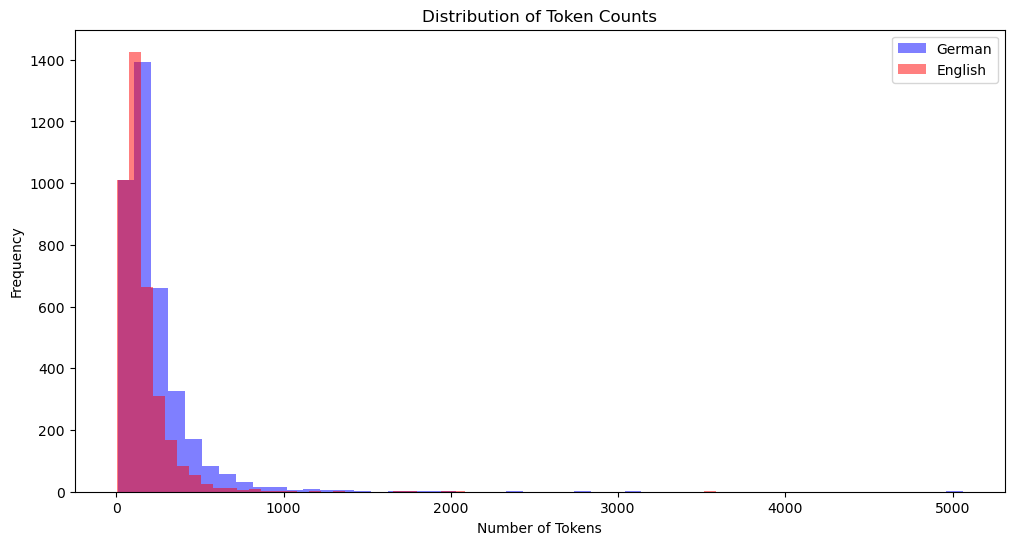

In [9]:
# Compute summary statistics
german_stats = df['german_token_count'].describe().round(2)
english_stats = df['english_token_count'].describe().round(2)
total_stats = df['total_token_count'].describe().round(2)

# Calculate total token counts
german_total = df['german_token_count'].sum()
english_total = df['english_token_count'].sum()
overall_total = df['total_token_count'].sum()

# Print token count statistics
print("German Token Count Statistics:")
print(german_stats)
print(f"Total German Tokens: {german_total}")

print("\nEnglish Token Count Statistics:")
print(english_stats)
print(f"Total English Tokens: {english_total}")

print("\nTotal Token Count Statistics:")
print(total_stats)
print(f"Overall Total Tokens: {overall_total}")

# Create distribution plot
plt.figure(figsize=(12, 6))
plt.hist(df['german_token_count'], bins=50, alpha=0.5, label='German', color='blue')
plt.hist(df['english_token_count'], bins=50, alpha=0.5, label='English', color='red')
plt.title('Distribution of Token Counts')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Word distribution

In [10]:
# Function to count words
def count_words(text):
    return len(text.split())

# Count words for German and English text
df['german_word_count'] = df['German Text'].apply(count_words)
df['english_word_count'] = df['English Text'].apply(count_words)
df['total_word_count'] = df['german_word_count'] + df['english_word_count']

In [11]:
df.head()

,German Text,English Text,german_token_count,english_token_count,total_token_count,german_word_count,english_word_count,total_word_count
0,Caspar Krause von dittersbach: Demnach er von ...,Caspar Krause from dittersbach: Since he was a...,295,227,522,144,169,313
1,Christoff weber von Bullendorf. Demnach er deu...,Christoff weber from Bullendorf. Since he was ...,232,184,416,117,142,259
2,Schwert hat zuegesagt das was er dieß mahl ver...,Schwert promises that he will not commit the o...,70,50,120,40,48,88
3,Jacob Nünner der Müllner. Demnach den Wolgebor...,"Jacob Nünner der Müllner. Since Jacob Nünner, ...",365,203,568,170,141,311
4,\nderer von Schwantz vnterthanen Zum Neundorff...,\nThe sers of the von Schwantz in Neundorff. S...,207,141,348,88,96,184


German Word Count Statistics:
count    3797.00
mean      102.32
std       104.68
min         2.00
25%        47.00
50%        77.00
75%       125.00
max      2532.00
Name: german_word_count, dtype: float64
Total German Words: 388527

English Word Count Statistics:
count    3797.00
mean      112.59
std       114.67
min         2.00
25%        52.00
50%        84.00
75%       138.00
max      2651.00
Name: english_word_count, dtype: float64
Total English Words: 427517

Total Word Count Statistics:
count    3797.00
mean      214.92
std       219.03
min         4.00
25%        99.00
50%       160.00
75%       263.00
max      5183.00
Name: total_word_count, dtype: float64
Overall Total Words: 816044


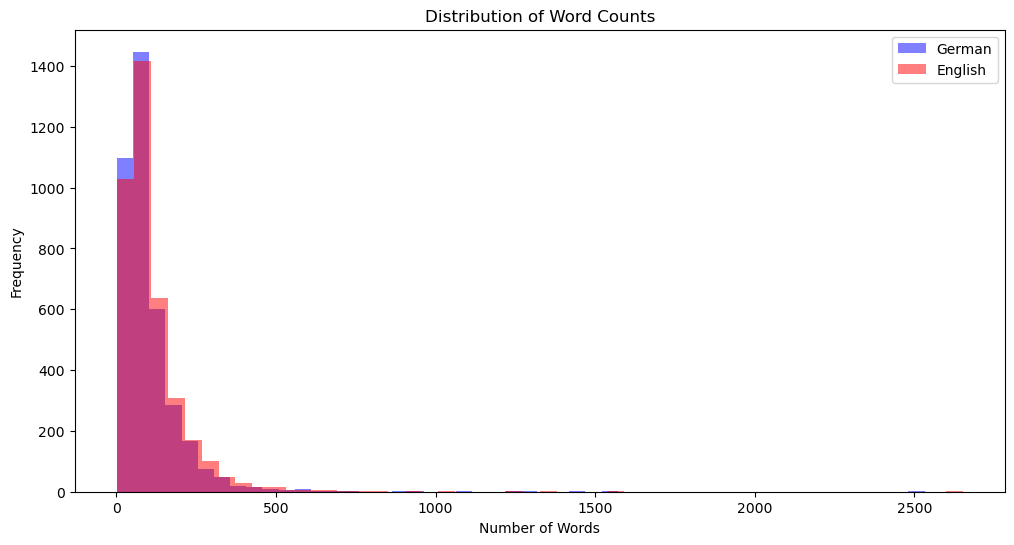

In [12]:
# Compute summary statistics
german_stats = df['german_word_count'].describe().round(2)
english_stats = df['english_word_count'].describe().round(2)
total_stats = df['total_word_count'].describe().round(2)

# Calculate total word counts
german_total = df['german_word_count'].sum()
english_total = df['english_word_count'].sum()
overall_total = df['total_word_count'].sum()

# Print word count statistics
print("German Word Count Statistics:")
print(german_stats)
print(f"Total German Words: {german_total}")

print("\nEnglish Word Count Statistics:")
print(english_stats)
print(f"Total English Words: {english_total}")

print("\nTotal Word Count Statistics:")
print(total_stats)
print(f"Overall Total Words: {overall_total}")

# Create distribution plot
plt.figure(figsize=(12, 6))
plt.hist(df['german_word_count'], bins=50, alpha=0.5, label='German', color='blue')
plt.hist(df['english_word_count'], bins=50, alpha=0.5, label='English', color='red')
plt.title('Distribution of Word Counts')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Clean text dataset
This code removes double whitespaces, wrong punctuation and inconsistent apostrophes.

In [13]:
# Function to clean text entries
def clean_text(text):

    # Remove unnecessary double white-spaces
    text = re.sub(r'\s{2,}', ' ', text)

    # Remove line breaks
    text = re.sub(r'[\n\r]+', ' ', text)

    # Remove substrings inside square brackets
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove any unmatched [ or ]
    text = re.sub(r'[\[\]]', '', text)
    
    # Remove unnecessary spaces before punctuation
    text = re.sub(r'\s+([.,;!?])', r'\1', text)
    
    # Fix spacing around apostrophes (replacing ’ with ')
    text = re.sub(r'\s+’\s+', r"'", text)
    
    # Fix double spaces or unnecessary whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [14]:
# Clean English Text
df['English Text'] = df['English Text'].apply(clean_text)

# Clean German Text
df['German Text'] = df['German Text'].apply(clean_text)

# Count how many entries have *** missing tokens

In [15]:
# Count the number of translation pairs with at least one '*' in either English Text or German Text
count_with_star = df[(df['English Text'].str.contains('\*')) | (df['German Text'].str.contains('\*'))].shape[0]

# Calculate the percentage relative to the total dataset length
percentage_with_star = (count_with_star / len(df)) * 100

print(f"Number of translation pairs with at least one '*': {count_with_star}")
print(f"Percentage of translation pairs with at least one '*': {percentage_with_star:.2f}%")

Number of translation pairs with at least one '*': 99
Percentage of translation pairs with at least one '*': 2.61%


In [16]:
# Filter the DataFrame to include only rows where at least one '*' is present
rows_with_star = df[(df['English Text'].str.contains('\*')) | (df['German Text'].str.contains('\*'))]

In [17]:
# Check row with *
rows_with_star['English Text'].iloc[8]

'Since he spoke of mayor and community court members in Seidenberg with defamatory words, similarly several times accused the corn-clerk in the manorial court of lying, for which reason he was put in jail, and let out now on petition of the pledges, on condition that he pay the lord his grace 6 Talers within 14 days, pledges are Michel Schafhirt and Bernhardt Bruckner from Seidenberg, 4 Mar 1585'

In [18]:
def filter_missing_entries(df, exclude_missing):
    """
    Filters out rows where either 'English Text' or 'German Text' contains a '*',
    based on the value of the exclude_missing parameter.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame with translation pairs.
    exclude_missing (bool): Whether to exclude rows with '*' in any of the text columns.
    
    Returns:
    pd.DataFrame: The filtered DataFrame.
    """
    if exclude_missing:
        # Filter out rows where either column contains a '*'
        df_filtered = df[~((df['English Text'].str.contains('\*')) | (df['German Text'].str.contains('\*')))]
    else:
        # If not excluding, return the original DataFrame
        df_filtered = df
    
    return df_filtered

In [19]:
# Example usage
filtered_df = filter_missing_entries(df, exclude_missing=exclude_missing)

In [20]:
# Check shape of filtered DataFrame
filtered_df.shape

(3698, 8)

# Exclude outliers with too many tokens

In [21]:
# Number of entries that meet the filtering condition
filtered_count = df[(df['german_token_count'] <= max_tokens) & (df['english_token_count'] <= max_tokens)].shape[0] #token count or word count?

# Total number of entries in the dataset
total_count = df.shape[0]

# Calculate the percentage
percentage = (filtered_count / total_count) * 100

print(f"Number of entries with too many tokens: {total_count - filtered_count}")
print(f"Percentage of total dataset: {100 - percentage:.2f}%")

Number of entries with too many tokens: 6
Percentage of total dataset: 0.16%


In [22]:
def filter_exclude_outliers(df, exclude_outliers, max_tokens):
    """
    Filters out rows where either 'german_word_count' or 'english_word_count' exceeds max_tokens,
    based on the value of the exclude_outliers parameter.

    Parameters:
    df (pd.DataFrame): The input DataFrame with translation pairs.
    exclude_outliers (bool): Whether to exclude rows where word counts exceed max_tokens.
    max_tokens (int): The maximum number of tokens allowed in either column before exclusion.

    Returns:
    pd.DataFrame: The filtered DataFrame.
    """
    if exclude_outliers:
        # Filter out rows where word count exceeds the maximum token limit
        filtered_df = df[(df['german_word_count'] <= max_tokens) & (df['english_word_count'] <= max_tokens)]
    else:
        # If not excluding outliers, return the original DataFrame
        filtered_df = df
    
    return filtered_df

In [23]:
filtered_df = filter_exclude_outliers(filtered_df, exclude_outliers, max_tokens)

In [24]:
filtered_df.shape

(3698, 8)

# Calculate average word difference between translation pairs

In [25]:
filtered_df.head()

,German Text,English Text,german_token_count,english_token_count,total_token_count,german_word_count,english_word_count,total_word_count
2,Schwert hat zuegesagt das was er dieß mahl ver...,Schwert promises that he will not commit the o...,70,50,120,40,48,88
3,Jacob Nünner der Müllner. Demnach den Wolgebor...,"Jacob Nünner der Müllner. Since Jacob Nünner, ...",365,203,568,170,141,311
4,derer von Schwantz vnterthanen Zum Neundorff. ...,The sers of the von Schwantz in Neundorff. Sin...,207,141,348,88,96,184
5,Melchior Rössels Zue Rückersdorff handtgelübni...,Melchior Rössel from Rückersdorf's hand-promis...,166,88,254,70,53,123
6,Hanß Nicht vnnd Mathes weber von Raspenaw. Dem...,Hanß Nicht and Mathes weber from Raspenaw. Bec...,256,168,424,126,131,257


Average difference in word counts: 10.14034613304489


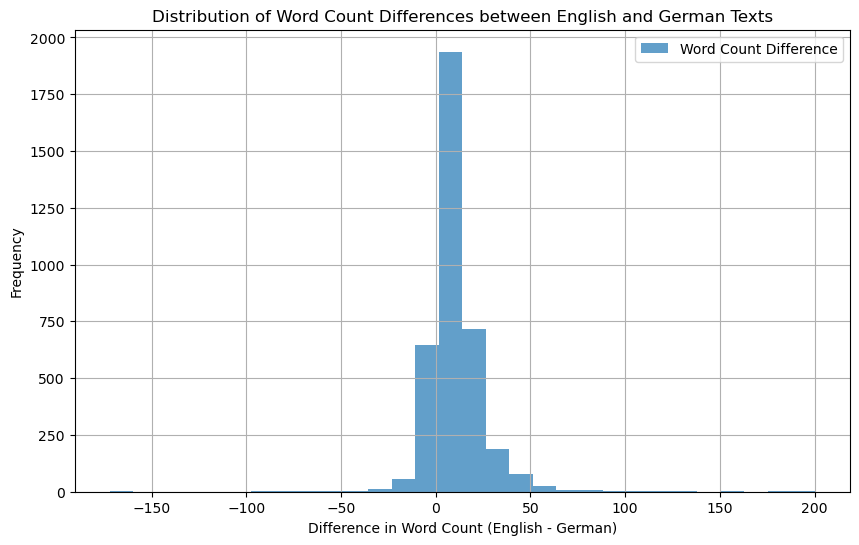

In [26]:

# Compute the difference in word counts between English and German
filtered_df['word_count_diff'] = filtered_df['english_word_count'] - filtered_df['german_word_count']

# Calculate the average of the differences
average_diff = filtered_df['word_count_diff'].mean()
print(f"Average difference in word counts: {average_diff}")

# Plot the distribution of the word count differences
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['word_count_diff'], bins=30, alpha=0.7, label='Word Count Difference')
plt.xlabel('Difference in Word Count (English - German)')
plt.ylabel('Frequency')
plt.title('Distribution of Word Count Differences between English and German Texts')
plt.legend()
plt.grid(True)
plt.show()

# Saved cleaned dataset

In [27]:
# Rename columns
filtered_df = filtered_df.rename(columns={"German Text": "Early Modern Bohemian German", "English Text": "English"})

# Keep only the specified columns
filtered_df = filtered_df[['Early Modern Bohemian German', 'English']]

In [28]:
filtered_df.head()

,Early Modern Bohemian German,English
2,Schwert hat zuegesagt das was er dieß mahl ver...,Schwert promises that he will not commit the o...
3,Jacob Nünner der Müllner. Demnach den Wolgebor...,"Jacob Nünner der Müllner. Since Jacob Nünner, ..."
4,derer von Schwantz vnterthanen Zum Neundorff. ...,The sers of the von Schwantz in Neundorff. Sin...
5,Melchior Rössels Zue Rückersdorff handtgelübni...,Melchior Rössel from Rückersdorf's hand-promis...
6,Hanß Nicht vnnd Mathes weber von Raspenaw. Dem...,Hanß Nicht and Mathes weber from Raspenaw. Bec...


In [29]:
# Save the filtered dataset as an Excel file
filtered_df.to_excel(save_path, index=False)

print("Filtered dataset saved as 'cleaned_historical_dataset.xlsx'.")

Filtered dataset saved as 'cleaned_historical_dataset.xlsx'.


In [30]:
filtered_df

,Early Modern Bohemian German,English
2,Schwert hat zuegesagt das was er dieß mahl ver...,Schwert promises that he will not commit the o...
3,Jacob Nünner der Müllner. Demnach den Wolgebor...,"Jacob Nünner der Müllner. Since Jacob Nünner, ..."
4,derer von Schwantz vnterthanen Zum Neundorff. ...,The sers of the von Schwantz in Neundorff. Sin...
5,Melchior Rössels Zue Rückersdorff handtgelübni...,Melchior Rössel from Rückersdorf's hand-promis...
6,Hanß Nicht vnnd Mathes weber von Raspenaw. Dem...,Hanß Nicht and Mathes weber from Raspenaw. Bec...
...,...,...
3792,Joseph Preyßler halb auen haußler macht das sc...,Joseph Preyßler half commons-cottager makes th...
3793,Der bey schliessige Auß zueg auß den G: amtl. ...,The enclosed extract from the gracious manoria...
3794,"Gotfried Hanisch sich excipiert, daß diese anz...","Gotfried Hanisch presents excuse, that this re..."
3795,Gleich die mann nun diesem Marienthaler antrag...,Now since this application by Marienthal is fo...
